<span>
<img src="http://ndlib.readthedocs.io/en/latest/_static/ndlogo2.png" width="260px" align="right"/>
</span>
<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  3.6<br/>
<b>NDlib version:</b>  4.0.1<br/>
<b>Last update:</b> 25/09/2018
</span>

<a id='top'></a>
# *Intro to NDlib: Network Diffusion library*

``NDlib`` is a python library designed to provide support to the analysis of diffusive phenomena occurring on top of complex network structures.

In this notebook are introduced some of the main features of the library and an overview of its functionalities.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started.

## Table of Contents

1. [Installing NDlib](#install)
2. [Simulation Workflow](#workflow)
    1. [Graph Creation](#graph)
    2. [Model Selection and Configuration](#model)
    3. [Simulation Execution](#simulation)
    4. [Results Visualisation](#visual)
3. [Available models](#models)
    1. [Epidemics](#epidemics)
    2. [Opinion Dynamics](#opinion)
4. [Advanced Model Configurations](#advanced)
    1. [Node Attributes](#nodes)
    2. [Edge Attributes](#edges)
    3. [Infection Seeds Selection](#seeds)
        1. [Model Stability](#stability)
        2. [Stability Visualisation](#stability_vis)
5. [Comparing Diffusion models](#comparing)
6. [Diffusion on Dynamic Networks](#dynamic)
    1. [DynetX: a library for dynamic network modeling](#dynetx)
        1. [Snapshot Graphs](#snapshots)
        2. [Interaction Networks](#interactions)
    2. [Available models](#models2)
    3. [Example: SIR](#dynsir)
7. [Custom Model Definition](#custom)
    1. [Compartments](#compartments)
        1. [Node compartments](#nc)
        2. [Edge compartments](#ec)
        3. [Time compartments](#tc)
    2. [Compartments Composition](#composition)
        1. [Cascading Composition](#cascading)
        2. [Conditional Composition](#conditional)
    3. [Example: SIR](#sir)
8. [NDQL: Network Diffusion Query Language](#ndql)
    1. [Syntax](#syntax)
    2. [Command line tools](#cmd)
    3. [Example: SIR](#sir2)
9. [Conclusions](#conclusion)

<a id='install'></a>
## 1. Installing NDlib ([to top](#top))

As a first step, we need to make sure that ``NDlib`` is installed and working.

The library is available for both python 2.7 and 3.x, and its stable version can be installed using ``pip``:

    pip install ndlib

On the project [GitHub](https://github.com/GiulioRossetti/ndlib) are also available the nightly builds that can be installed as follows:

    pip install git+https://github.com/GiulioRossetti/ndlib.git > /dev/null

In order to check if ``ndlib`` has been correctly installed just try to import it

In [1]:
!pip install ndlib
import ndlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.2/110.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 43.0 MB/s eta 0:00:00


<a id='workflow'></a>
## 2. Simulation Workflow ([to top](#top))

``Ndlib`` breaks the simulation of diffusive phenomena into a standard workflow:
- Network Creation
- Diffusion model Selection and Configuration
- Simulation execution
- Results visualisation

In this section we will observe how to templating such workflow describing a simple *SIR* simulation.

<img src="img/sir.png"/>

<a id="graph"></a>
### 2.A Graph object creation ([to top](#top))

As a first step we need to define the network topology that will be used as playground to study diffusive phenomena.

``NDlib`` leverage [``networkx``](https://networkx.github.io) data structure to provide support for both directed and undirected graphs.

In this example, to perform our simulation, we instantiate a Erdos-Renyi graph as follows:

In [2]:
import networkx as nx

g = nx.erdos_renyi_graph(1000, 0.1)

<a id="model"></a>
### 2.B Model Selection and Configuration ([to top](#top))

After having defined the graph, we can select the diffusion model to simulate. In our example we import the SIR model and instantiate it on our graph.

In [5]:
from ndlib.models.epidemics import SIRModel

model = SIRModel(g)

Every diffusion model has its own parameter, ``NDlib`` offers a common interface to specify them: ``ModelConfig``.
``ModelConfig`` takes care of validating model parameters.

Indeed, every model has its own parameters: model specific parameter list and definitions are available on the project [documentation site](http://ndlib.readthedocs.io).

In order to get a description of the required parameters just access the ``parameter`` field

In [6]:
import json
print(json.dumps(model.parameters, indent=2))

{
  "model": {
    "beta": {
      "descr": "Infection rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "gamma": {
      "descr": "Recovery rate",
      "range": [
        0,
        1
      ],
      "optional": false
    },
    "tp_rate": {
      "descr": "Whether if the infection rate depends on the number of infected neighbors",
      "range": [
        0,
        1
      ],
      "optional": true,
      "default": 1
    }
  },
  "nodes": {},
  "edges": {}
}


Similarly, to obtain a list of the statuses implemented in the selected model just access the ``available_statuses`` field

In [7]:
model.available_statuses

{'Susceptible': 0, 'Infected': 1, 'Removed': 2}

In [8]:
import ndlib.models.ModelConfig as mc

cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001) # infection rate
cfg.add_model_parameter('gamma', 0.01) # recovery rate

``ModelConfig`` also allows to describe the initial condition of the simulation. It makes possible, for instance, to specify the initial percentage of infected nodes in the network.

In [9]:
cfg.add_model_parameter("percentage_infected", 0.01)
model.set_initial_status(cfg)

<a id="simulation"></a>
### 2.C Simulation Execution ([to top](#top))

Once described the network, the model and the initial conditions it is possible to perform the simulation.

``NDlib`` models diffusive phenomena as **discrete-time**, **agent-based** processes: during every iteration all nodes are evaluated and, their statuses are updated accordingly to the model rules.

Iterations can be required (incrementally) by using two methods:
- ``iteration()``
- ``iteration_bunch(nbunch, node_status=False)``

The former computes a single iteration step, the latter executes ``nbunch`` iterations.

The ``node_status`` parameter allows to return the individual node status at each iteration.

In [10]:
iterations = model.iteration_bunch(200, node_status=True)
iterations

[{'iteration': 0,
  'status': {0: 0,
   1: 0,
   2: 0,
   3: 0,
   4: 0,
   5: 0,
   6: 0,
   7: 0,
   8: 0,
   9: 0,
   10: 0,
   11: 0,
   12: 0,
   13: 0,
   14: 0,
   15: 0,
   16: 0,
   17: 0,
   18: 0,
   19: 0,
   20: 0,
   21: 0,
   22: 0,
   23: 0,
   24: 0,
   25: 0,
   26: 0,
   27: 0,
   28: 0,
   29: 0,
   30: 0,
   31: 0,
   32: 0,
   33: 0,
   34: 0,
   35: 0,
   36: 0,
   37: 0,
   38: 0,
   39: 0,
   40: 0,
   41: 0,
   42: 0,
   43: 0,
   44: 0,
   45: 1,
   46: 0,
   47: 0,
   48: 0,
   49: 0,
   50: 0,
   51: 1,
   52: 0,
   53: 0,
   54: 0,
   55: 0,
   56: 0,
   57: 0,
   58: 0,
   59: 0,
   60: 0,
   61: 0,
   62: 0,
   63: 0,
   64: 0,
   65: 0,
   66: 0,
   67: 0,
   68: 0,
   69: 0,
   70: 0,
   71: 0,
   72: 0,
   73: 0,
   74: 0,
   75: 0,
   76: 0,
   77: 0,
   78: 0,
   79: 0,
   80: 0,
   81: 0,
   82: 0,
   83: 0,
   84: 0,
   85: 0,
   86: 0,
   87: 0,
   88: 0,
   89: 0,
   90: 0,
   91: 0,
   92: 0,
   93: 0,
   94: 0,
   95: 0,
   96: 0,
   97: 0,
  

To abstract from iterations details it is possible to transform them into diffusion **trends** using the ``build_trends(iterations)`` method:

In [11]:
trends = model.build_trends(iterations)
trends

[{'trends': {'node_count': {0: [990,
     990,
     990,
     990,
     989,
     989,
     987,
     986,
     985,
     983,
     980,
     978,
     975,
     971,
     967,
     966,
     965,
     962,
     961,
     958,
     955,
     950,
     944,
     937,
     935,
     927,
     918,
     910,
     901,
     892,
     884,
     876,
     865,
     851,
     841,
     823,
     804,
     788,
     772,
     752,
     740,
     725,
     709,
     686,
     665,
     649,
     626,
     620,
     600,
     577,
     558,
     537,
     513,
     494,
     477,
     446,
     425,
     399,
     385,
     364,
     340,
     316,
     298,
     283,
     274,
     262,
     247,
     227,
     213,
     193,
     182,
     172,
     156,
     143,
     136,
     124,
     115,
     110,
     105,
     96,
     92,
     83,
     74,
     66,
     62,
     59,
     55,
     51,
     49,
     43,
     42,
     39,
     38,
     36,
     34,
     34,
     32,
     30,
     27,
   

<a id="top"></a>
###  2.D Results Visualisation ([to top](#top))

Finally, ``NDlib`` allows to inspect the behavior of the simulated model using standard plots such as the ``DiffusionTrend`` and ``DiffusionPrevalence`` ones.

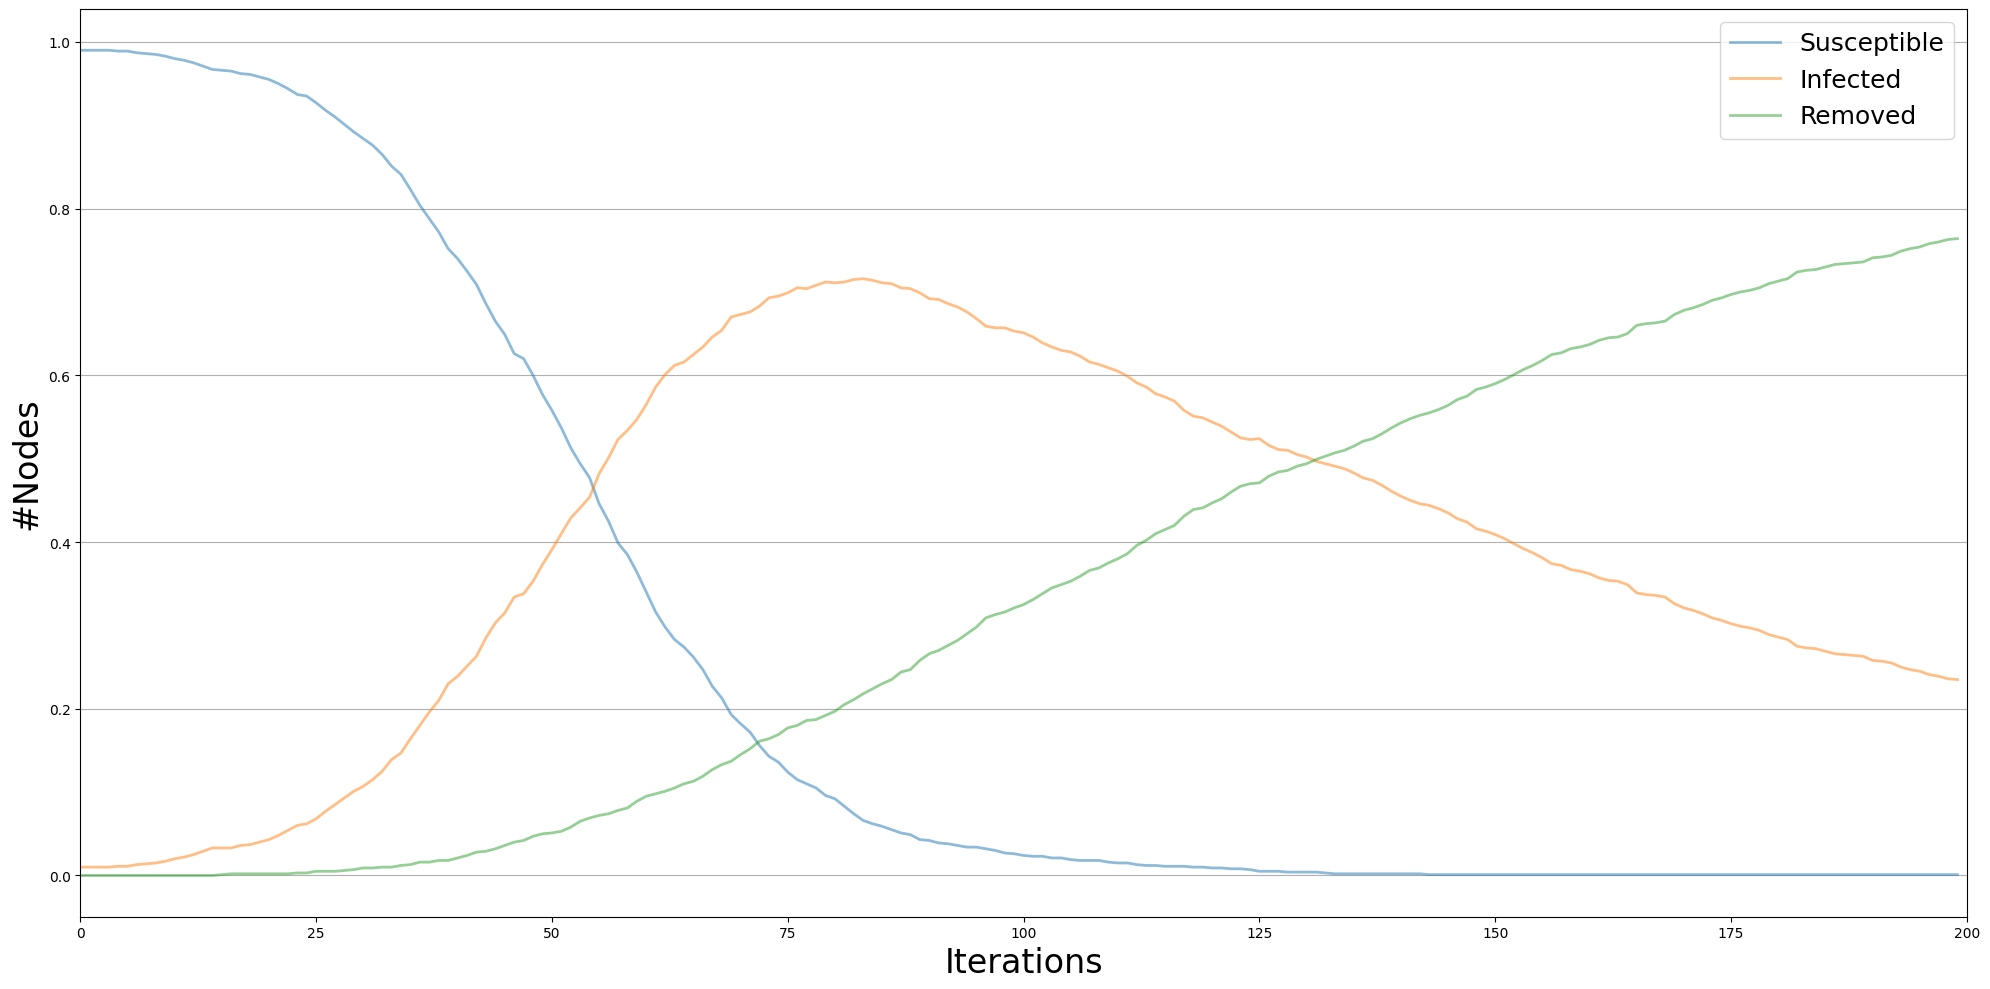

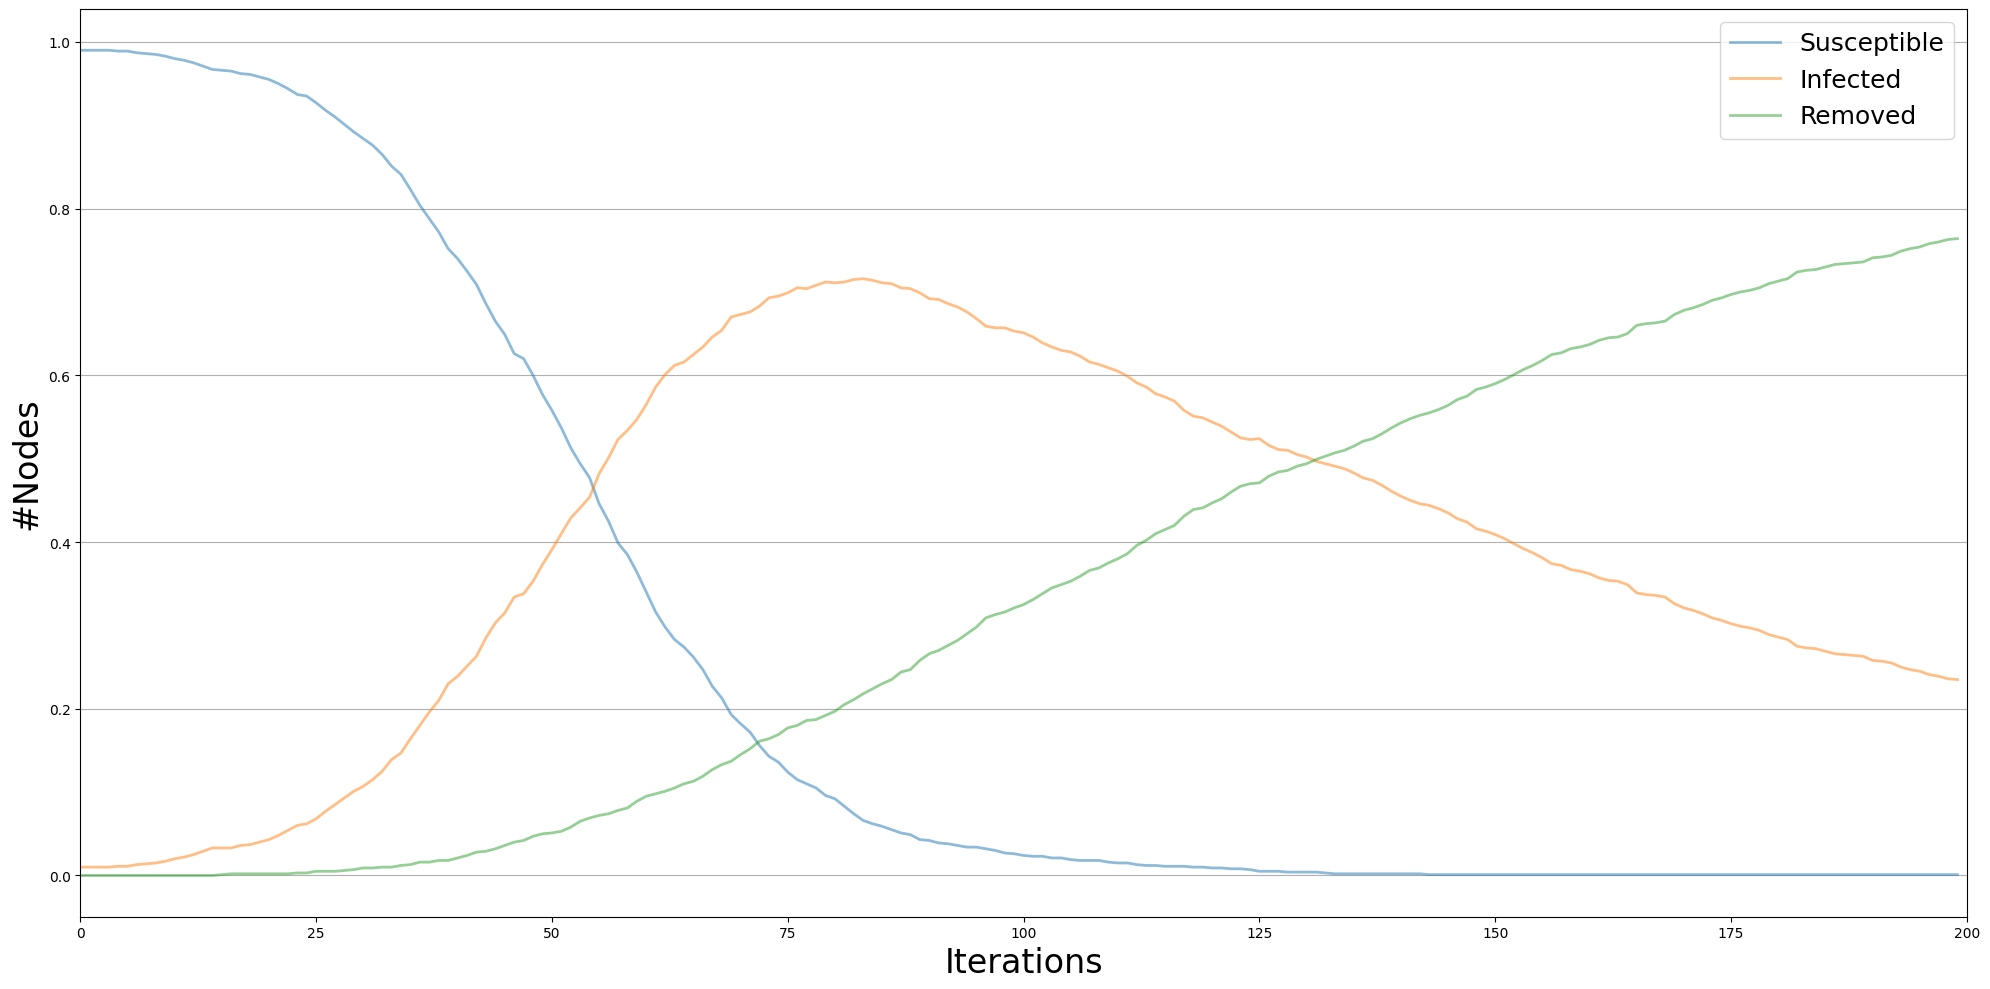

In [13]:
%matplotlib inline
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
viz = DiffusionTrend(model, trends)
viz.plot()

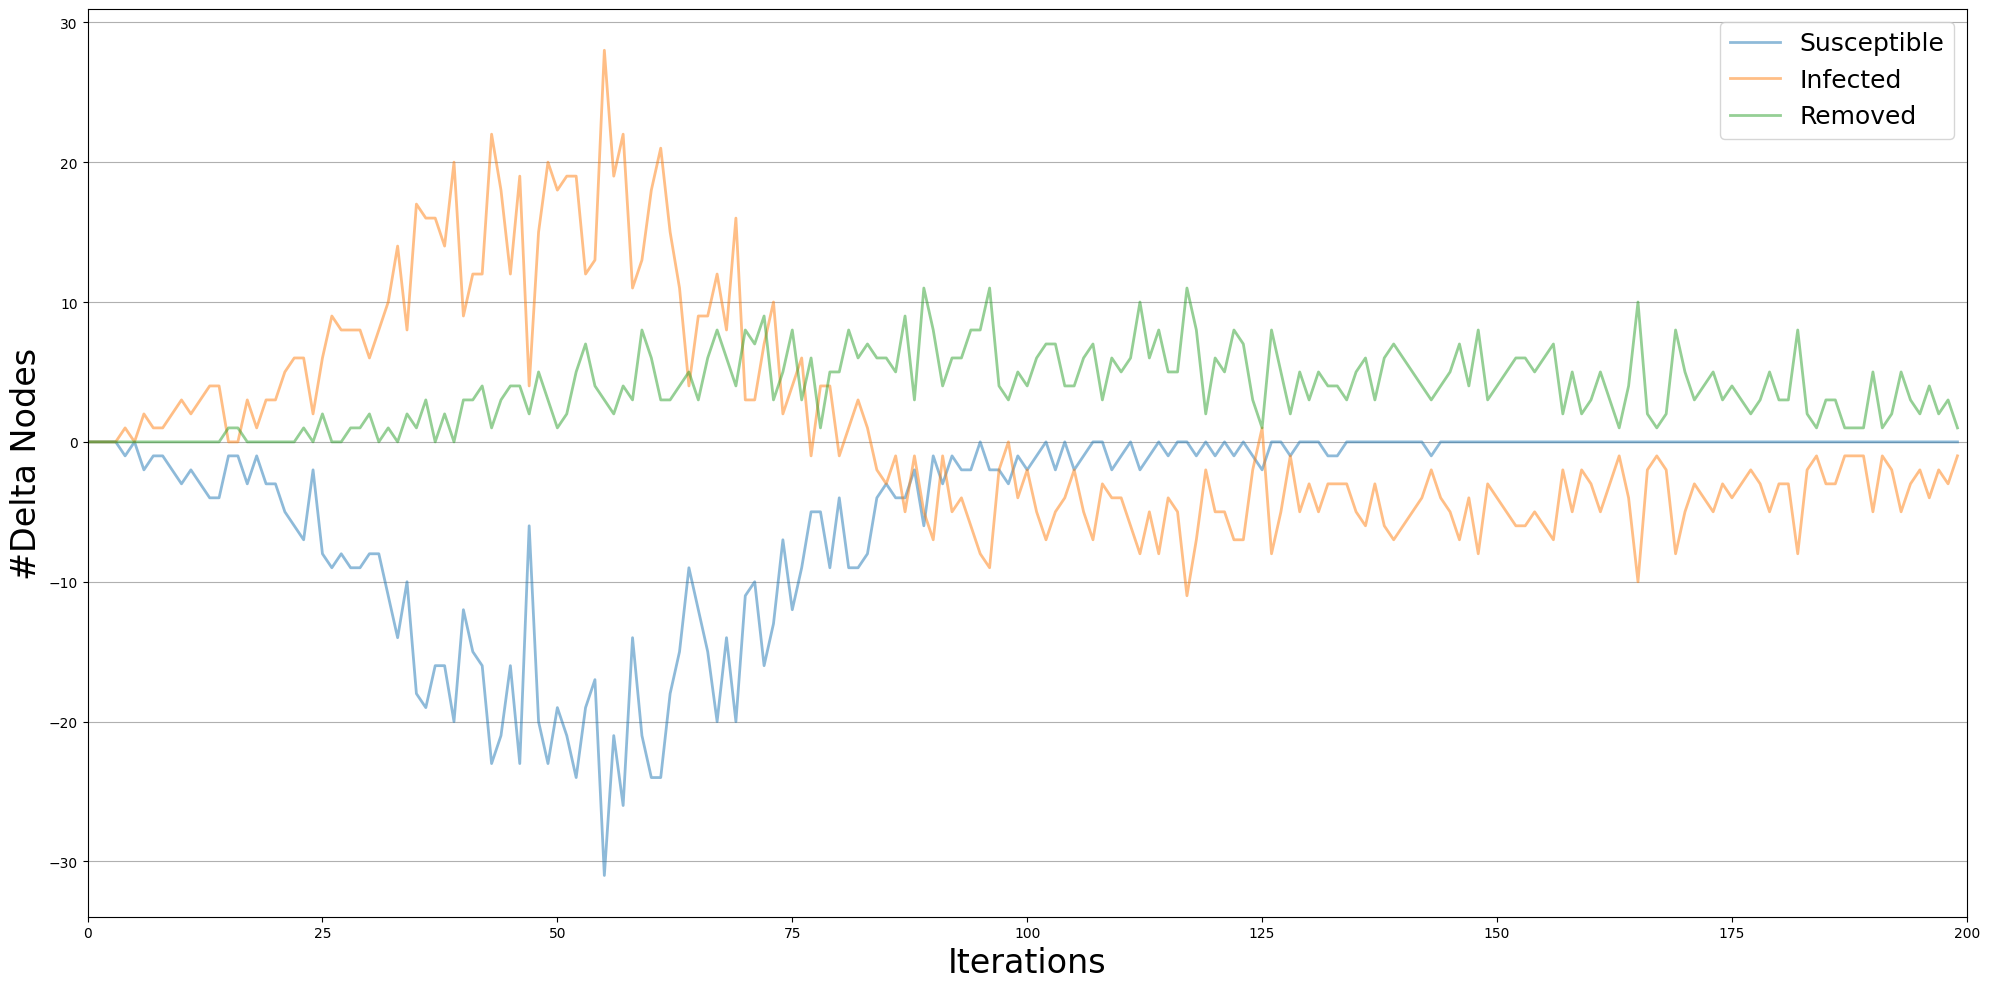

In [14]:
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
viz = DiffusionPrevalence(model, trends)
viz.plot()

The proposed visualisation are realised using the [``matplotlib``](https://matplotlib.org) python library. They are fully customizable and all the metadata they visualize is gathered by the ``model`` object.

To obtain web-oriented versions of such plots ``NDlib`` exposes a second visualisation endpoint built on top of [``bokeh``](https://bokeh.pydata.org/en/latest/): the plotting facilities its defines are collected within the sub-package ``ndlib.viz.bokeh`` and follow the same rationale of their ``matplotlib`` counterpart.

<a id="models"></a>
## 3. Available models ([to top](#top))

The analysis of diffusive phenomena that unfold on top of complex networks is a task able to attract growing interests from multiple fields of research.

In order to provide a succinct framing of such complex and extensively studied problem it is possible to split the related literature into two broad, related, sub-classes: **Epidemics** and **Opinion Dynamics**.

<a id="epidemics"></a>
### 3.A Epidemics ([to top](#top))

When we talk about epidemics, we think about contagious diseases caused by biological pathogens, like influenza, measles, chickenpox and sexually transmitted viruses that spread from person to person.

Several elements determine the patterns by which epidemics spread through groups of people: the properties carried by the pathogen (its contagiousness, the length of its infectious period and its severity), the structure of the network as well as the mobility patterns of the people involved.

In ``NDlib`` are implemented the following 12 Epidemic models:

<table>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIm.html'>SI</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIS.html'>SIS</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html'>SIR</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SEIR.html'>SEIR</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SEIS.html'>SEIS</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SWIR.html'>SWIR</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Threshold.html'>Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/GeneralisedThreshold.html'>Generalised Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/KThreshold.html'>Kertesz Threshold</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/Profile.html'>Profile</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/ProfileThreshold.html'>Profile-Threshold</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/epidemics/IndependentCascades.html'>Independent Cascades</a></td>
    </tr>
</table>

In [64]:
from ndlib.models import opinions as op
model = op.AlgorithmicBiasModel(g)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.32)
config.add_model_parameter("gamma", 0)  # No bias = Deffuant
model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)

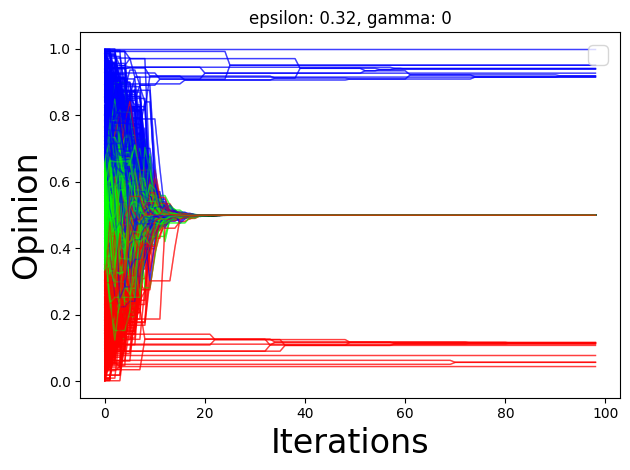

In [66]:
%matplotlib inline
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)
viz.plot()

<a id="opinions"></a>
### 3.B Opinion Dynamics ([to top](#top))

A different field related with modelling social behaviour is that of opinion dynamics.

Recent years have witnessed the introduction of a wide range of models that attempt to explain how opinions form in a population, taking into account various social theories (e.g. bounded confidence or social impact).

These models have a lot in common with those seen in epidemics and spreading. In general, individuals are modelled as agents with a state and connected by a social network.

The social links can be represented by a complete graph (*mean field* models) or by more realistic complex networks, similar to epidemics and spreading.

The state is typically represented by variables, that can be *discrete* (similar to the case of spreading), but also *continuous*, representing for instance a probability to choose one option or another. The state of individuals changes in time, based on a set of update rules, mainly through interaction with the neighbours.

While in many spreading and epidemics models this change is irreversible (susceptible to infected), in opinion dynamics the state can oscillate freely between the possible values, simulating thus how opinions change in reality.

In ``NDlib`` are implemented the following 6 Opinion Dynamics models:

<table>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/Voter.html'>Voter</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/QVoter.html'>Q-Voter</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/MajorityRule.html'>Majority Rule</a></td>
    </tr>
    <tr>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/Snajzd.html'>Sznajd</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/COD.html'>Cognitive Opinion Dynamics</a></td>
        <td><a href='http://ndlib.readthedocs.io/en/latest/reference/models/opinion/AlgorithmicBias.html'>Algorithmic Bias</a></td>
    </tr>
</table>

<a id="comparing"></a>
## 5. Comparing Diffusion models ([to top](#top))

A common goal for which diffusion simulations are executed is to perform comparison among different models (or different instantiations of a same model).

To address such demands ``NDlib`` provides visual comparison plots.

To show how they work, as a first step we execute a second model (in this exampe an **SI** model) over our original graph.

In [59]:
from ndlib.utils import multi_runs
from ndlib.models.epidemics import SIModel
model1 = SIModel(g)
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.001)
cfg.add_model_parameter("percentage_infected", 0.01)
model1.set_initial_status(cfg)

trends1 = multi_runs(model1, execution_number=10, iteration_number=100, nprocesses=4)

Then, we can compare them:

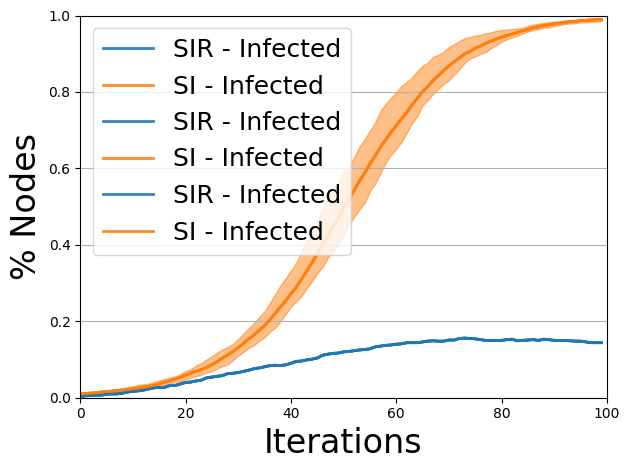

In [62]:
%matplotlib inline
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
viz = DiffusionTrendComparison([model, model1], [trends, trends1], statuses=['Infected'])
viz.plot()

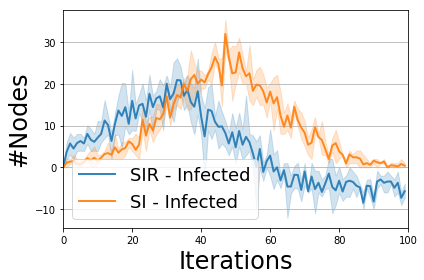

In [ ]:
from ndlib.viz.mpl.PrevalenceComparison import DiffusionPrevalenceComparison
viz = DiffusionPrevalenceComparison([model, model1], [trends, trends1], statuses=['Infected'])
viz.plot()

The method parameter ``statuses`` takes as input a list of the models statuses trends we want to compare.
So, for instance, if we are interested in comparing both the trends for *Infected* and *Susceptible* nodes we can do something like this:

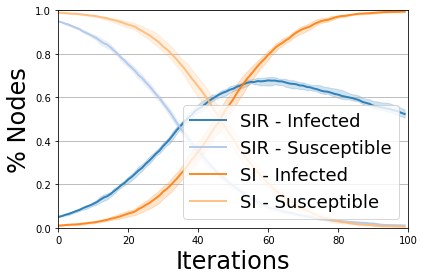

In [ ]:
from ndlib.viz.mpl.TrendComparison import DiffusionTrendComparison
viz = DiffusionTrendComparison([model, model1], [trends, trends1], statuses=['Infected', 'Susceptible'])
viz.plot()

<a id="conclusion"></a>
## Exercises ([to top](#top))


**Scenario**

You’re an analyst tasked with understanding how COVID-19 might propagate through a mid-size office. The office seating plan has both clustered workgroups (teams) and occasional cross-team interactions (meetings, breakroom).


Generate a Watts–Strogatz small-world graph with 200 nodes, each node representing an employee.

- Each node connected to its 6 nearest neighbours on a ring (k = 6).
- Rewiring probability p = 0.1 to simulate occasional cross-team contacts.

In [15]:
# 1. Graph creation: Watts–Strogatz small-world
G = nx.watts_strogatz_graph(n=200, k=6, p=0.1)

**Model Selection & Configuration**

Choose an appropriate epidemics model. Consider Covid-19's characteristics. Initialise with 2% of nodes infected.

In [47]:
model = SIRModel(G)
cfg   = mc.Configuration()
cfg.add_model_parameter('beta',              0.03)    # infection rate
cfg.add_model_parameter('gamma',             0.01)    # recovery rate
cfg.add_model_parameter('percentage_infected', 0.02)  # 2% seeds
model.set_initial_status(cfg)

Run the simulation for 100 time steps.

In [48]:
# 3. Run simulation for 100 iterations
iterations = model.iteration_bunch(100)

# 4. Build trends
trends = model.build_trends(iterations)

Plot both DiffusionTrend and DiffusionPrevalence.

Identify (visually) the iteration at which active infections peak. Estimate (visually) the amount of recovered agents at the end of the simulation

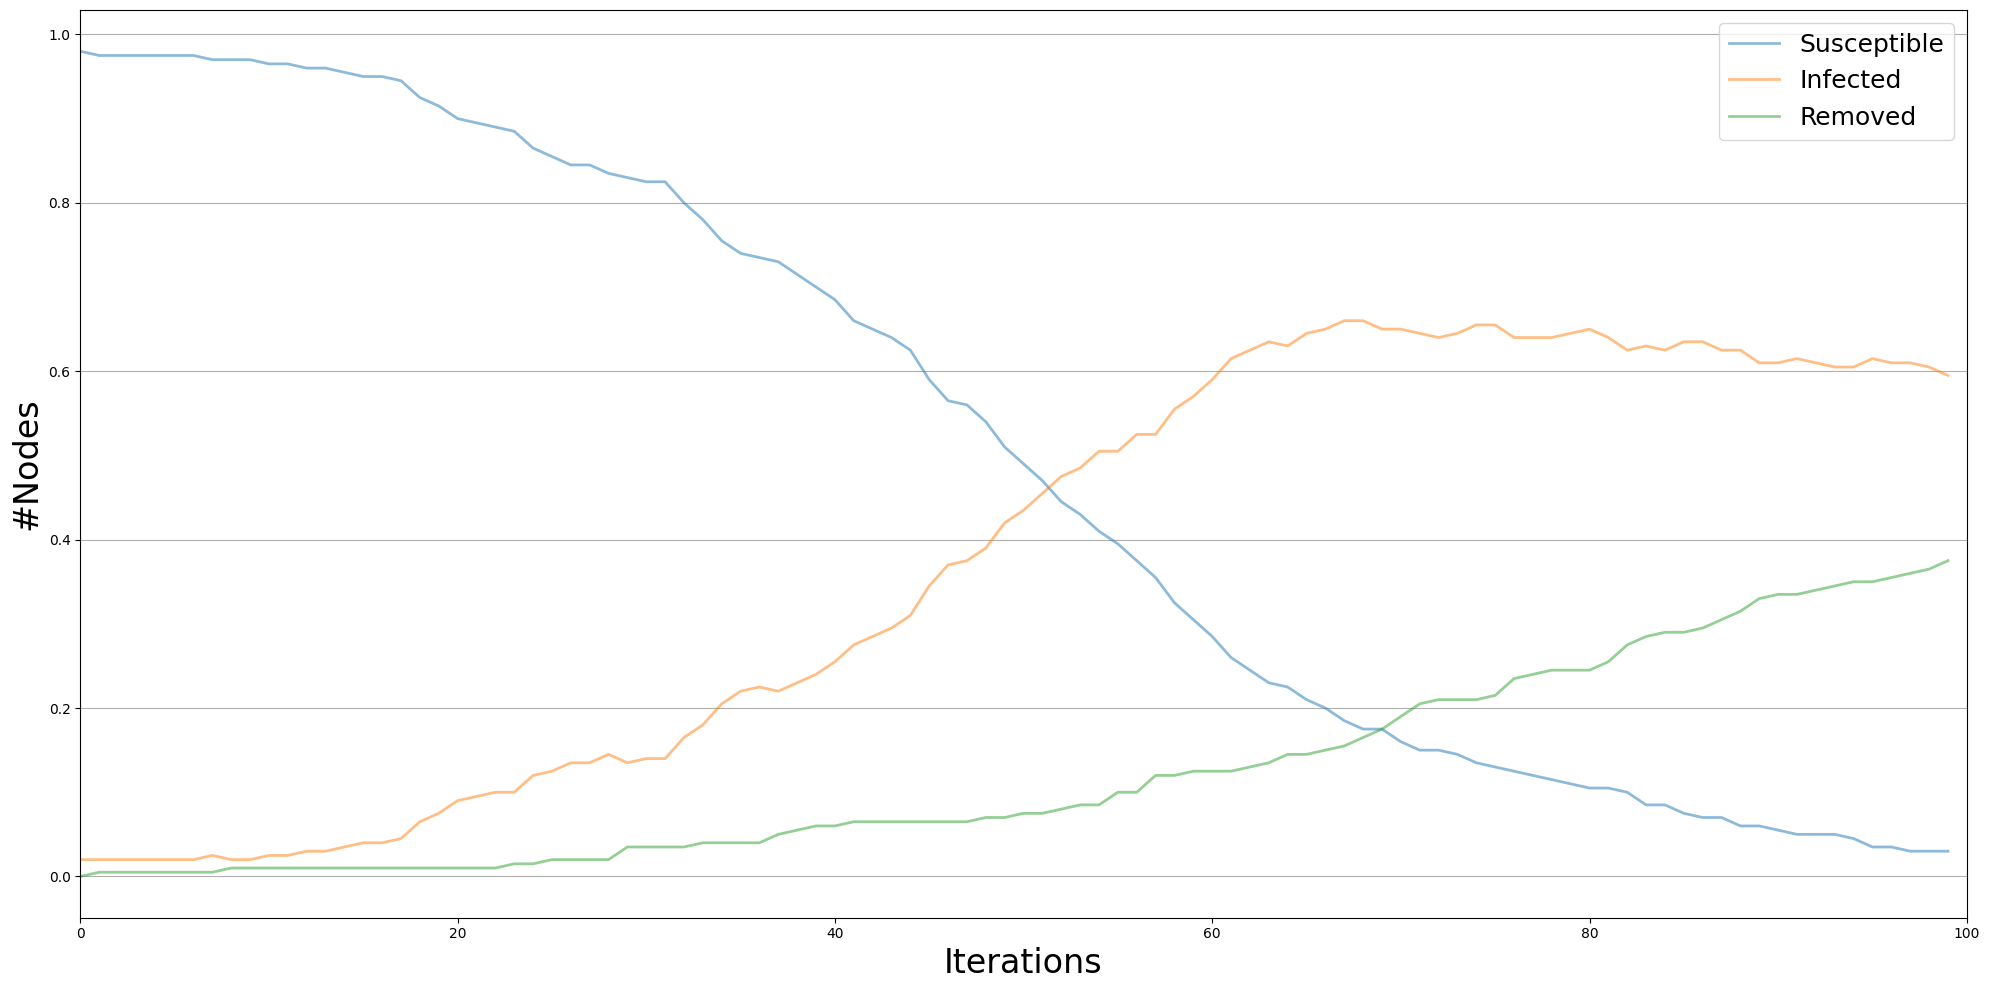

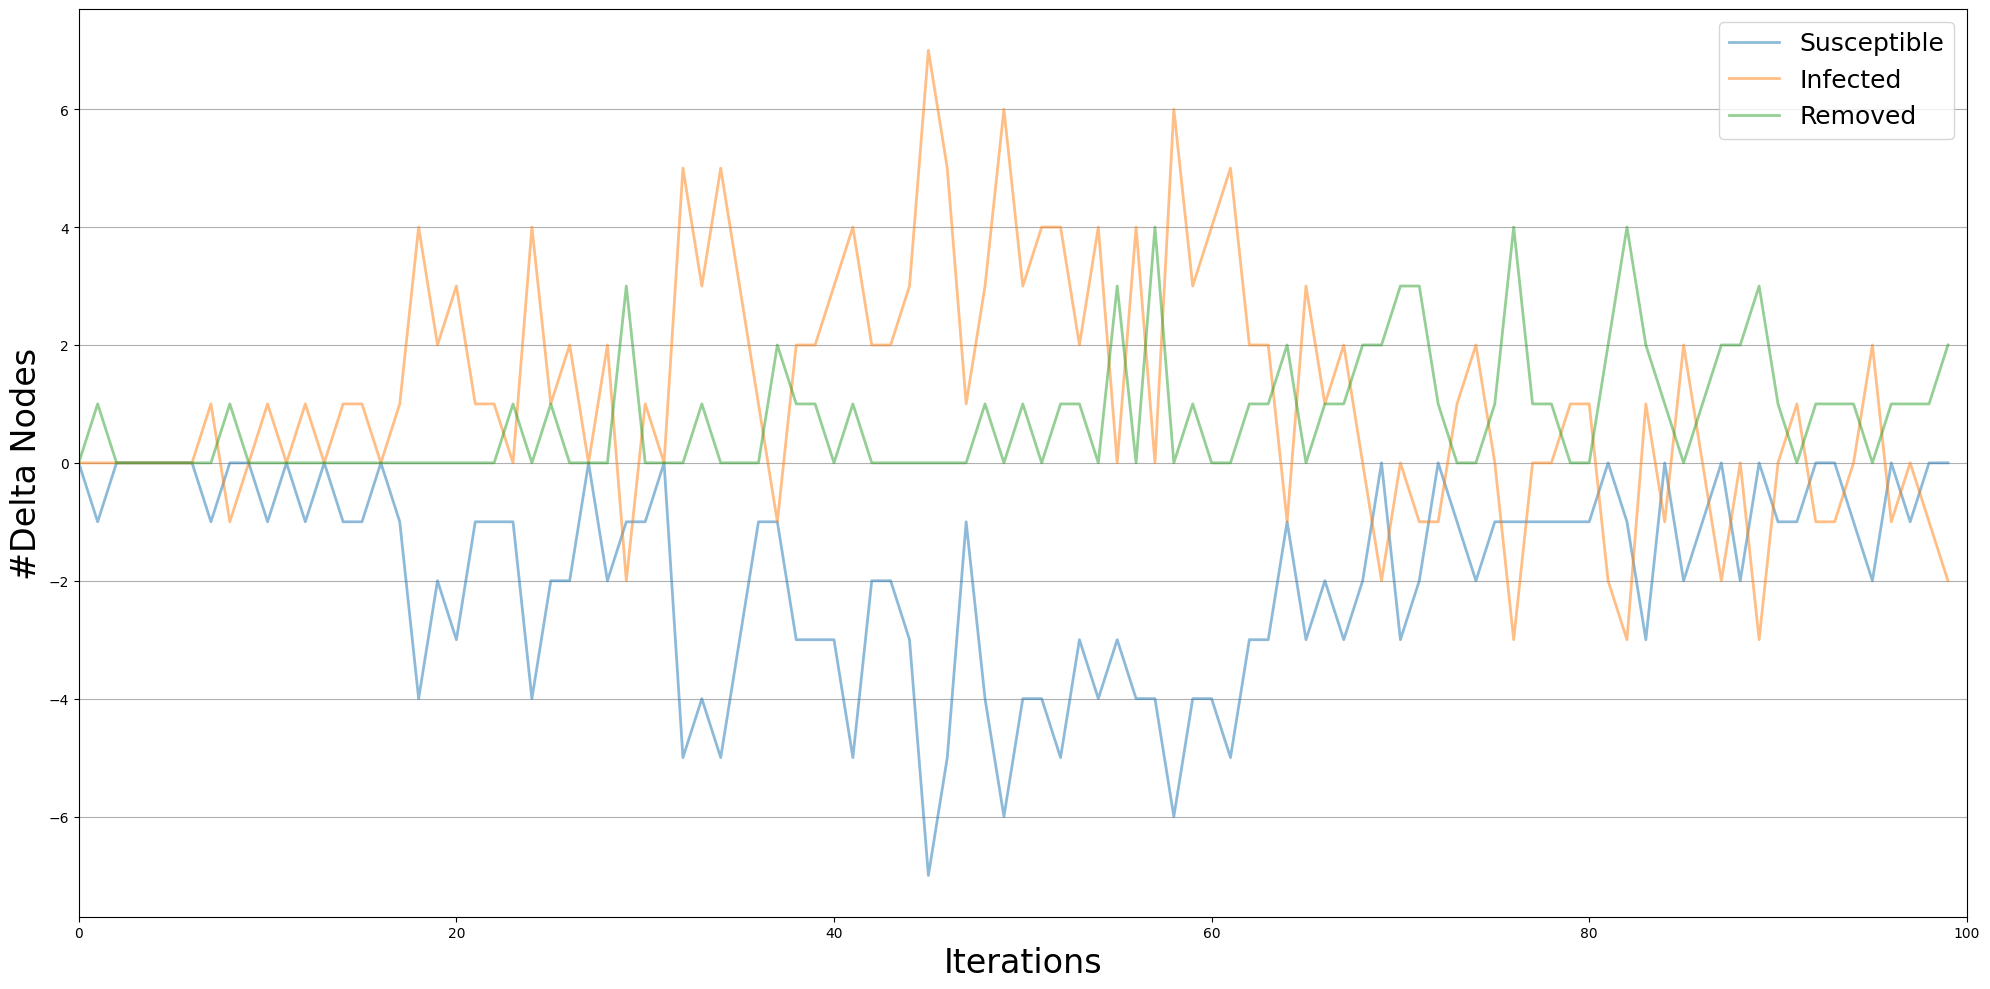

In [49]:
viz = DiffusionTrend(model, trends)
viz.plot()    # Active S, I, R over time

viz = DiffusionPrevalence(model, trends)
viz.plot()    # Cumulative prevalence (I + R)


How does increasing β change peak timing and size?

In [52]:
model = SIRModel(G)
cfg   = mc.Configuration()
cfg.add_model_parameter('beta',              0.10)    # infection rate
cfg.add_model_parameter('gamma',             0.01)    # recovery rate
cfg.add_model_parameter('percentage_infected', 0.02)  # 2% seeds
model.set_initial_status(cfg)
iterations = model.iteration_bunch(100)
trends = model.build_trends(iterations)


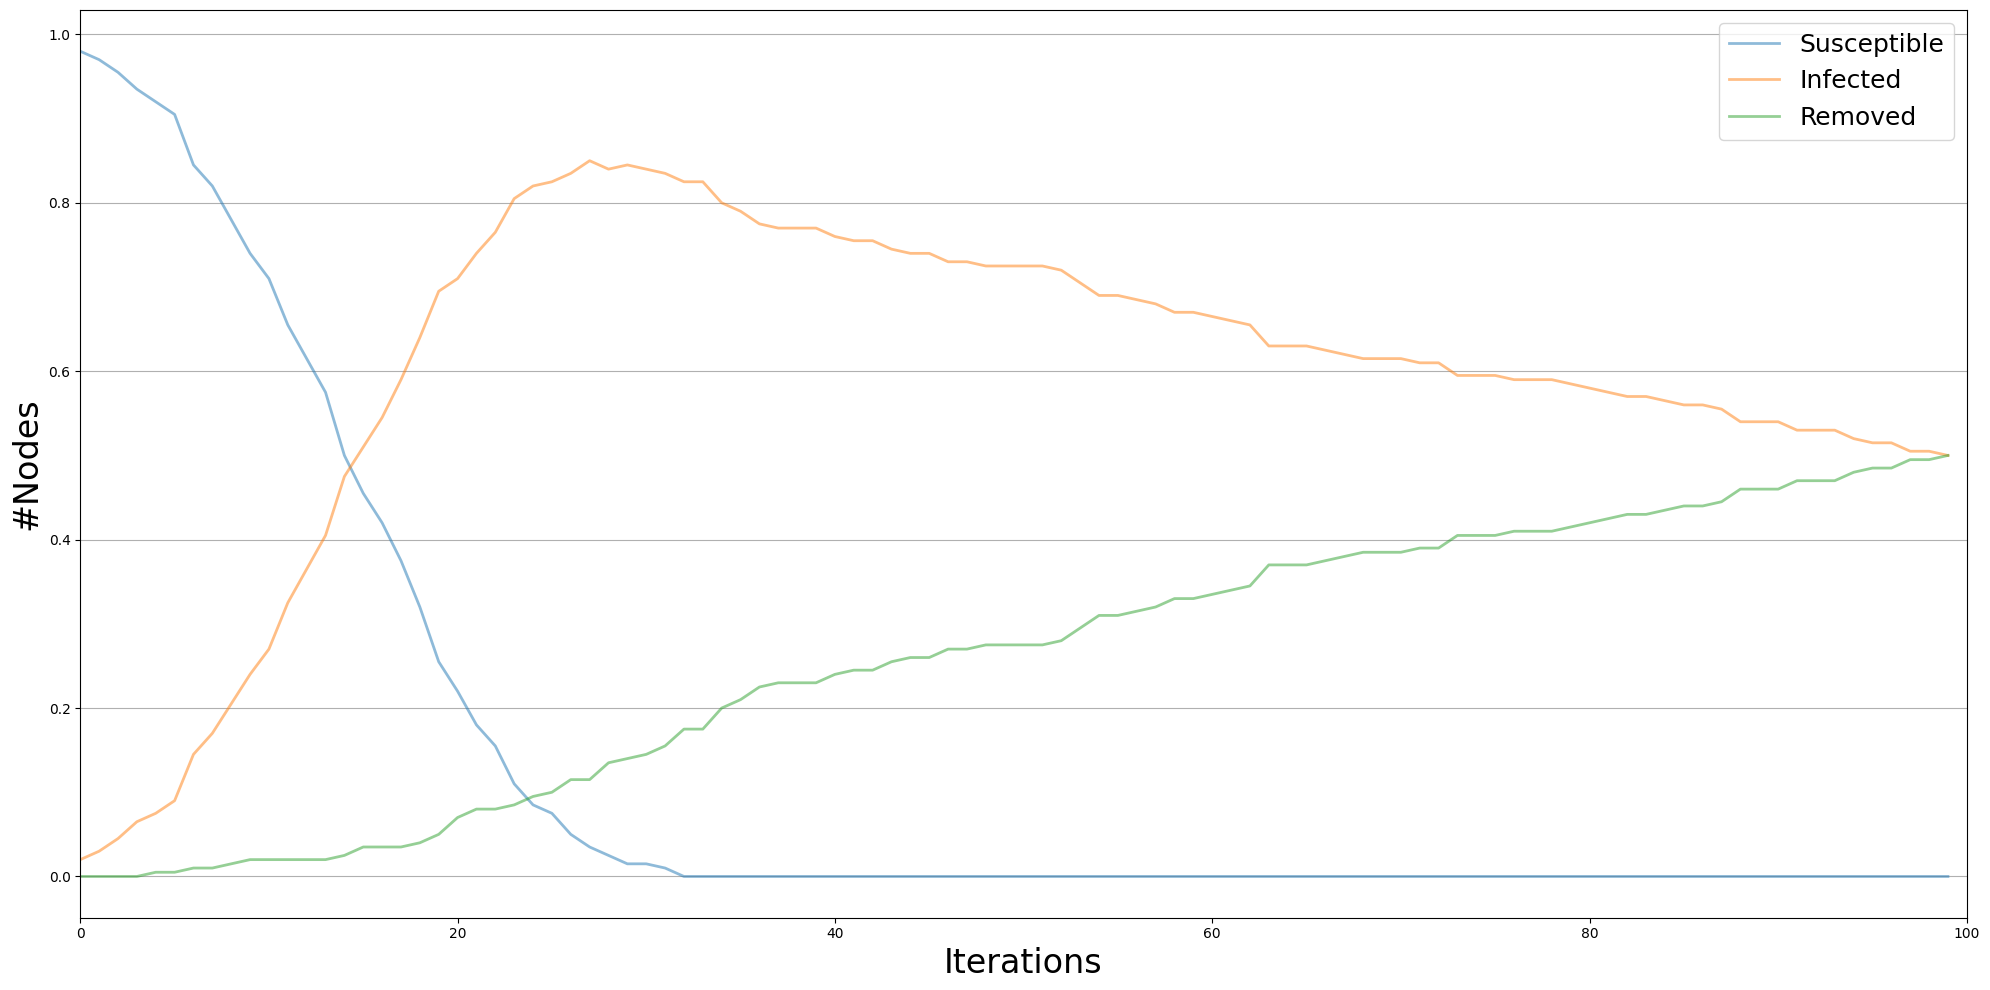

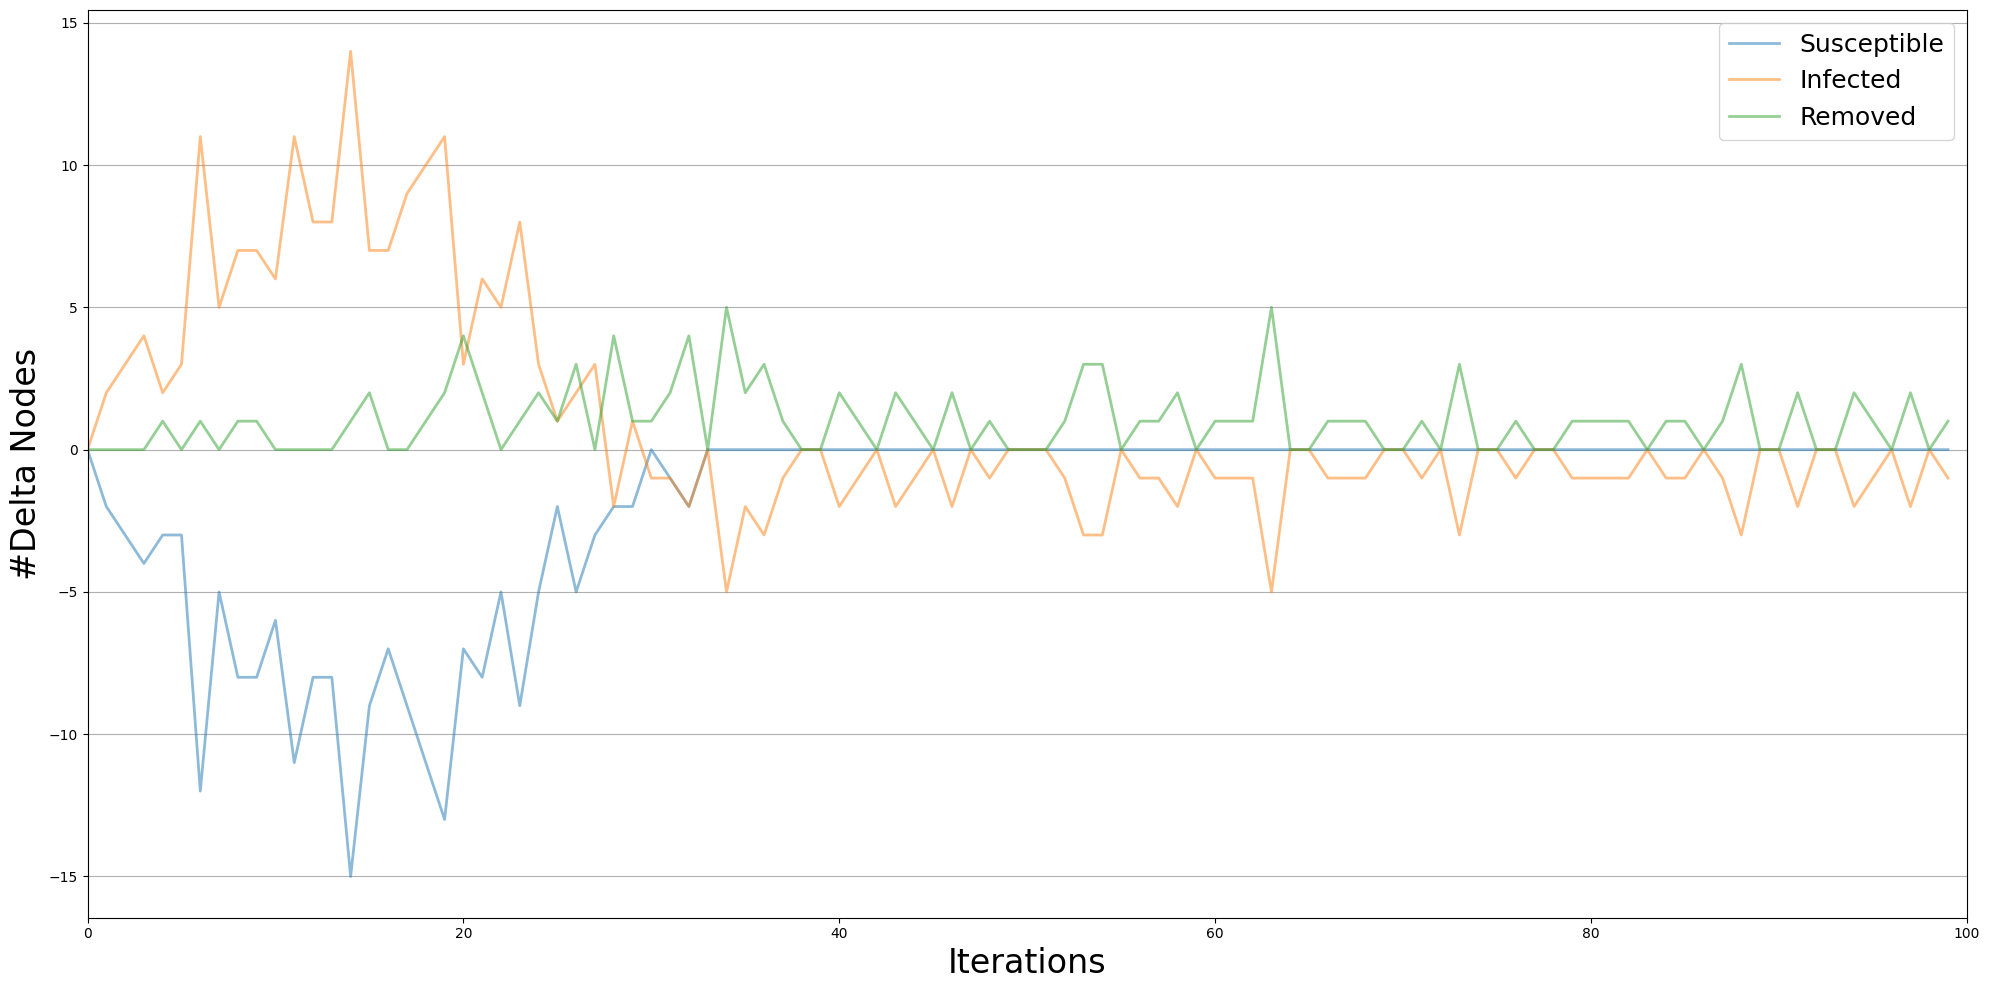

In [53]:
viz = DiffusionTrend(model, trends)
viz.plot()    # Active S, I, R over time

viz = DiffusionPrevalence(model, trends)
viz.plot()    # Cumulative prevalence (I + R)


What if you reduce γ (slower recovery)? (keep β as in the first execution).

In [56]:
model = SIRModel(G)
cfg   = mc.Configuration()
cfg.add_model_parameter('beta',              0.03)    # infection rate
cfg.add_model_parameter('gamma',             0.005)    # recovery rate
cfg.add_model_parameter('percentage_infected', 0.02)  # 2% seeds
model.set_initial_status(cfg)

iterations = model.iteration_bunch(100)
trends = model.build_trends(iterations)

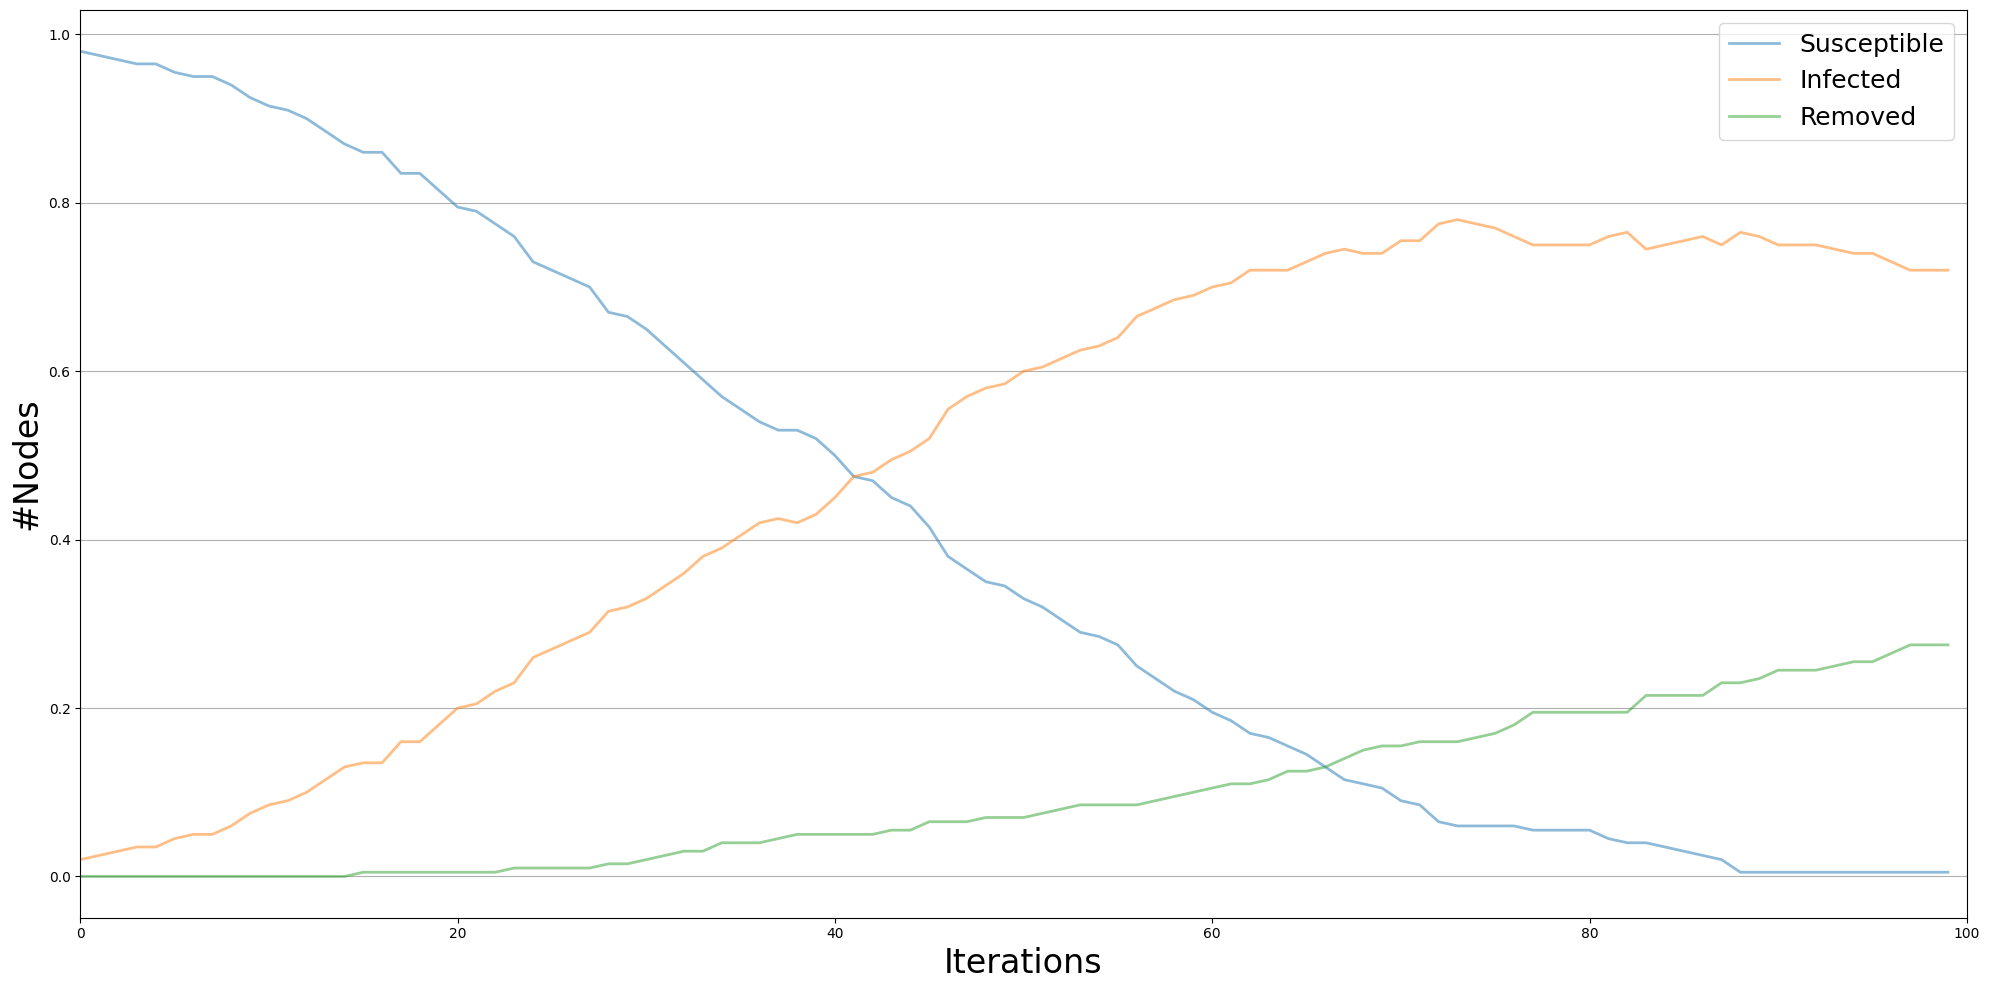

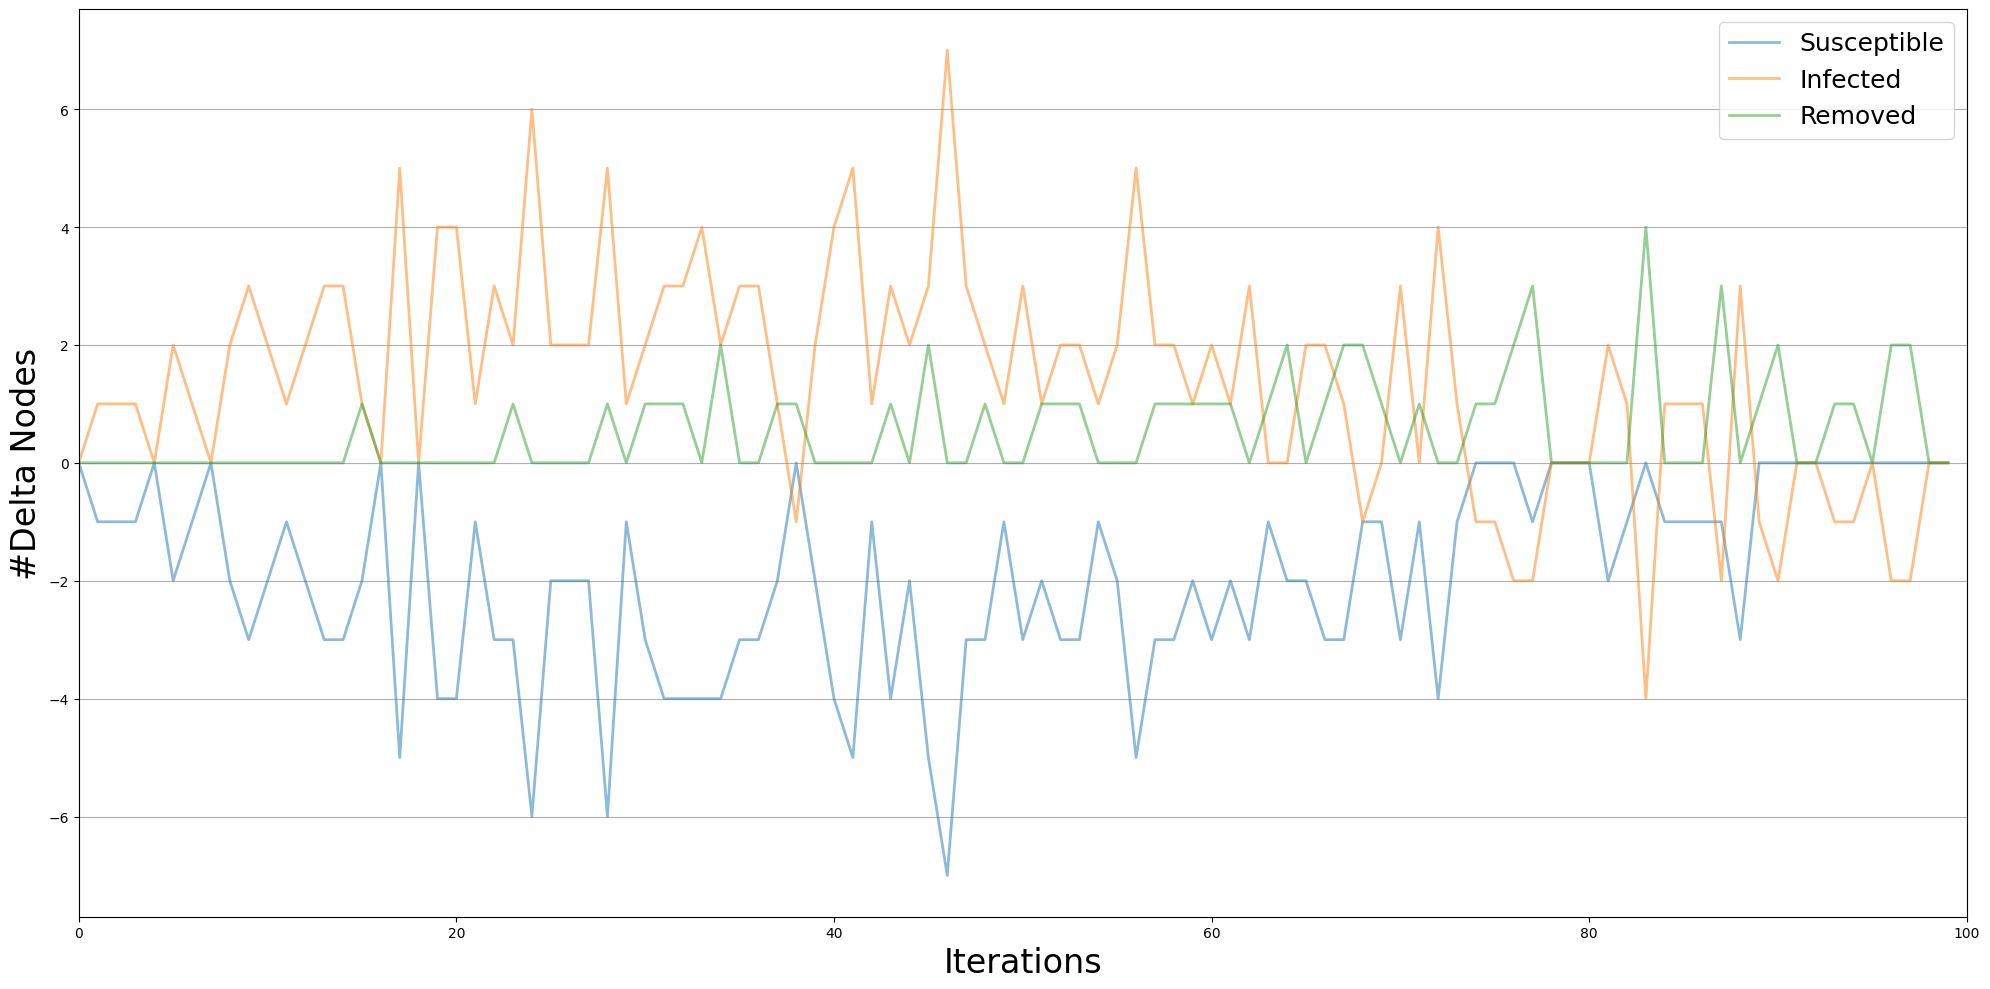

In [57]:
viz = DiffusionTrend(model, trends)
viz.plot()    # Active S, I, R over time

viz = DiffusionPrevalence(model, trends)
viz.plot()    # Cumulative prevalence (I + R)


### Exercise 2
You’re a social scientist studying how opinions converge or polarize in an online community. You’ll use a bounded‐confidence model with algorithmic bias to see how individuals adjust their views through pairwise interactions. Specifically, you want to understand how different recommendation systems affect opinion formation.

Generate a Barabási–Albert scale-free graph with 200 nodes (users), where each new node attaches to 3 existing nodes (m = 3):

In [67]:
g = nx.barabasi_albert_graph(n=200, m=3)

**Model Selection & Configuration**

- Use the Algorithmic bias from ndlib.models.opinions.
- Set the bounded confidence to 0.3.
- set the algorithmic bias to 1
- Then run the model for 100 iterations


In [98]:
from ndlib.models.opinions import AlgorithmicBiasModel

model = AlgorithmicBiasModel(g)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.3)
config.add_model_parameter("gamma",1)
model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)

Visualize the opinion evolution

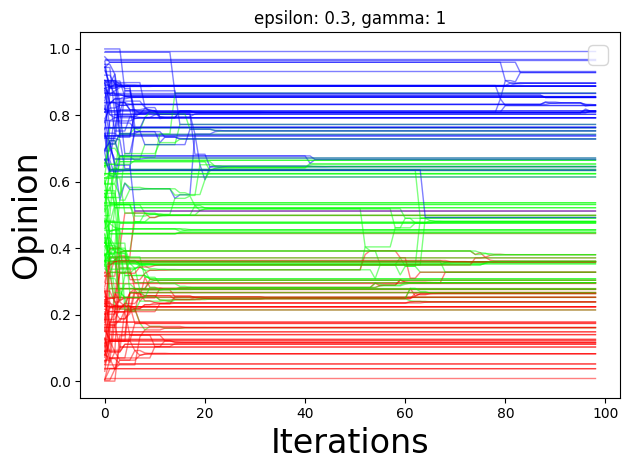

In [99]:
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)
viz.plot()

Compare with a setting where no algorithmic effect is present

In [103]:
from ndlib.models.opinions import AlgorithmicBiasModel

model = AlgorithmicBiasModel(g)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.3)
config.add_model_parameter("gamma",0)
model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)

Visualize opinion evolution

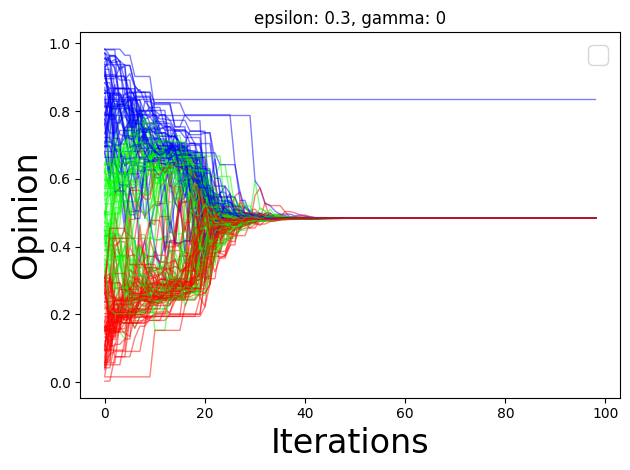

In [104]:
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)
viz.plot()

Change the algoithmic bias to 40 to simulate a more personalized/aggressive recommender.

In [107]:
from ndlib.models.opinions import AlgorithmicBiasModel

model = AlgorithmicBiasModel(g)

# Model configuration
config = mc.Configuration()
config.add_model_parameter("epsilon", 0.3)
config.add_model_parameter("gamma", 40)
model.set_initial_status(config)

# Simulation execution
iterations = model.iteration_bunch(100)

Visualize opinion evolution

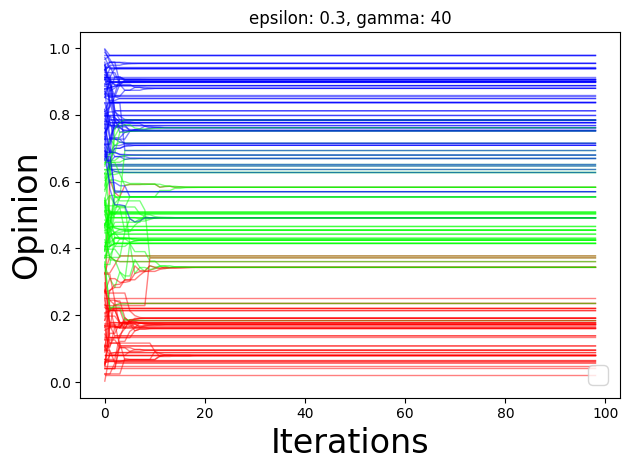

In [108]:
from ndlib.viz.mpl.OpinionEvolution import OpinionEvolution
viz = OpinionEvolution(model, iterations)
viz.plot()